# Chapter 4 Training Linear Models

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 线性回归模块导入
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.base import clone

from sklearn import datasets

## 正规方程法

$\theta = (X^T \cdot X)^{-1}\cdot X^T \cdot y$

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3*X + np.random.randn(100, 1)
X.shape

(100, 1)

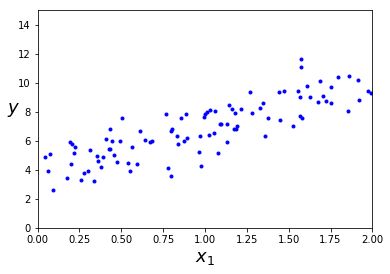

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize= 18)
plt.axis([0, 2, 0, 15])
plt.show()

In [4]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to X
theta_best  = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.81625065],
       [3.11743978]])

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.81625065],
       [10.0511302 ]])

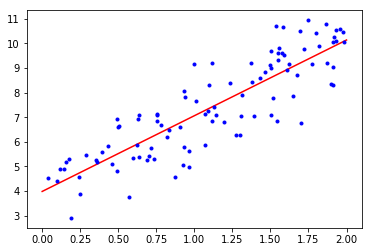

In [6]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.show()

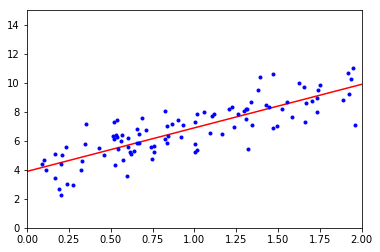

In [11]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

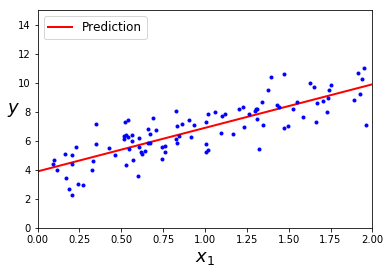

In [13]:
plt.plot(X_new, y_predict, "r-", linewidth = 2, label = "Prediction")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.legend(loc = "upper left", fontsize = 12)
plt.axis([0, 2, 0, 15])
plt.show()

## 线性回归

In [6]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.81625065]), array([[3.11743978]]))

In [7]:
lin_reg.predict(X_new)

array([[ 3.81625065],
       [10.0511302 ]])

## 线性回归-梯度下降

$\frac{\partial}{\partial \theta_j}MSE(\theta) = \frac{2}{m}\sum_{i = 1}^{m}(\theta^T \cdot x^{(i)} - y^{(i)})x_j^{(i)}$

$\nabla_\theta MSE(\theta) = \frac{2}{m}X^T \cdot (X\cdot \theta - y)$

In [8]:
eta = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta*gradients

In [17]:
theta

array([[3.89046889],
       [3.00425167]])

In [18]:
X_new_b.dot(theta)

array([[3.89046889],
       [9.89897224]])

In [9]:
theta_path_bgd = []

# 绘制迭代前10步的预测值
# 红色的线是初始theta值的那个点
def plot_gradient_descent(theta, eta, theta_path = None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize = 18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize = 16)

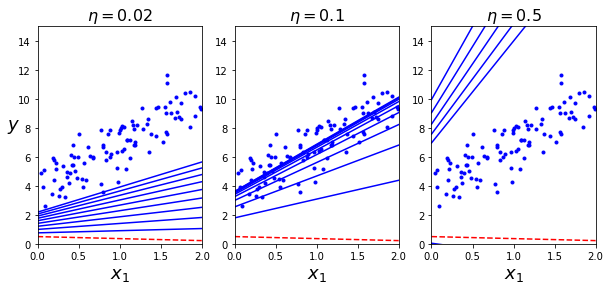

In [10]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize = (10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta = 0.02)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.subplot(132)
plot_gradient_descent(theta, eta = 0.1, theta_path = theta_path_bgd)
plt.subplot(133)
plot_gradient_descent(theta, eta = 0.5)

plt.show()

## 随机梯度下降 Stochastic Gradient Descent

随机梯度下降计算时，可能会越过最优值，解决办法是逐渐减少学习率。称为模拟退火法，因为它类似于冶金中熔化金属的退火过程慢慢冷却下来。在每次迭代中确定学习速率的函数被称为**学习时间表（learning schedule）**。

In [11]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

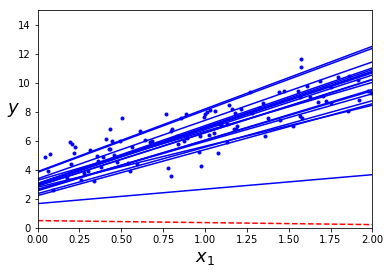

In [12]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0/(t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + 1)
        theta = theta - eta*gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.axis([0, 2, 0, 15])
plt.show()

In [33]:
theta

array([[3.94251934],
       [3.01448066]])

使用模块中自带函数计算。

In [34]:
sgd_reg = SGDRegressor(max_iter = 50, tol = -np.infty, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=50, n_iter=None, penalty=None,
       power_t=0.25, random_state=42, shuffle=True, tol=-inf, verbose=0,
       warm_start=False)

In [35]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.96536654]), array([3.0649029]))

## Mini-batch Gradient Descent

介于前两者之间，不是每次都计算所有样本数据，也不是一次计算一个样本，而是每次选取一个区间的数据计算梯度。

In [13]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 50

np.random.seed(42)
theta = np.random.randn(2, 1)

t0, t1 = 200, 1000

def learning_schedule(t):
    return t0/(t + t1)


t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [39]:
theta

array([[3.88596151],
       [3.00322167]])

In [14]:
# 绘制theta迭代值的图像
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)


print("bgd", len(theta_path_bgd))
print("sgd", len(theta_path_sgd))
print("mgd", len(theta_path_mgd))

bgd 1000
sgd 5000
mgd 100


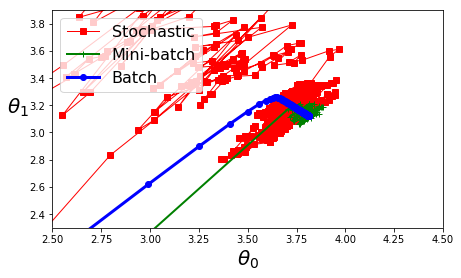

In [16]:
plt.figure(figsize = (7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

## 多项式

In [18]:
np.random.seed(42)
m = 100
X = 6*np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

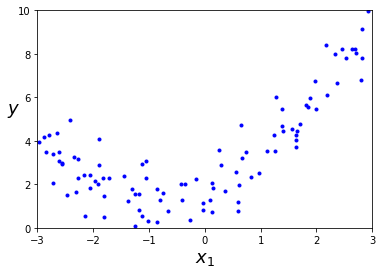

In [19]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [21]:
# from sklearn.preprocessing import PolymialFeatures
# 将多项式的值计算出来，采用线性拟合的方式
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X.shape, X_poly.shape

((100, 1), (100, 2))

In [22]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

In [23]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.fit_transform(X_new)
y_new = lin_reg.predict(X_new_poly)

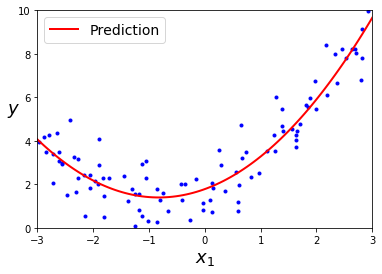

In [24]:
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth = 2, label = "Prediction")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.legend(loc = "upper left", fontsize = 14)
plt.axis([-3, 3, 0, 10])
plt.show()

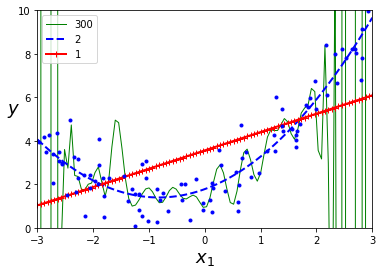

In [28]:
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree = degree, include_bias = False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg)
    ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label = str(degree), linewidth = width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
# save_fig("high_degree_polynomials_plot")
plt.show()

**绘制学习曲线**

In [33]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth = 2, label = "train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth = 3, label = "val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)

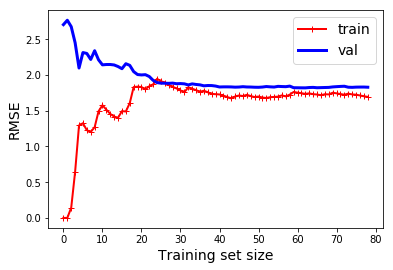

In [34]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

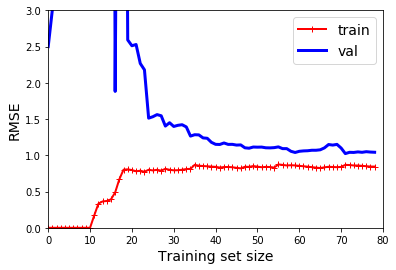

In [35]:
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 10, include_bias = False)),
    ("sgd_reg", LinearRegression()),
])
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

## 正则化-Ridge Regression

In [36]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ("poly_features", PolynomialFeatures(degree = 10, include_bias = False)),
                ("std_scler", StandardScaler()),
                ("regul_reg", model),
            ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth = lw, label = r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])



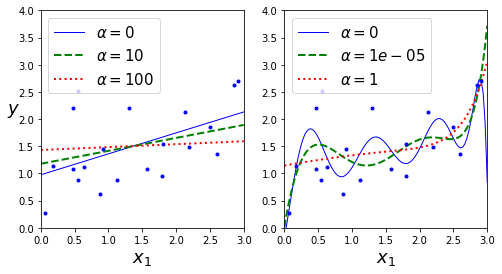

In [39]:
plt.figure(figsize = (8, 4))
plt.subplot(121)
# 非多项式
plot_model(Ridge, polynomial = False, alphas = (0, 10, 100), random_state = 42)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.subplot(122)
# 多项式
plot_model(Ridge, polynomial = True, alphas = (0, 10 ** -5, 1), random_state = 42)
plt.show()

In [40]:
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [41]:
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty="l2", random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.49905184])

In [42]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

## 正则化-Lasso Regression

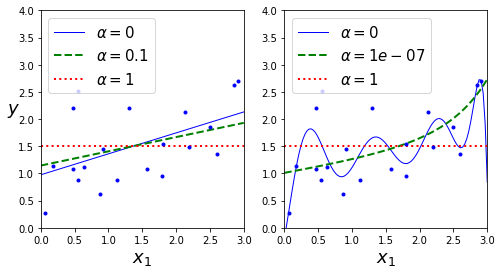

In [43]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)
plt.show()

In [44]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## 正则化-Elastic Net

介于前面两者之间，既有l1正则化，也l2正则化部分。

In [45]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

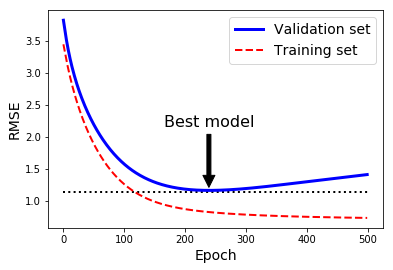

In [46]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
# save_fig("early_stopping_plot")
plt.show()

In [47]:
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
        
best_epoch, best_model

(239, SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.0005,
        fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
        loss='squared_loss', max_iter=1, n_iter=None, penalty=None,
        power_t=0.25, random_state=42, shuffle=True, tol=-inf, verbose=0,
        warm_start=True))

## Logistic Regression

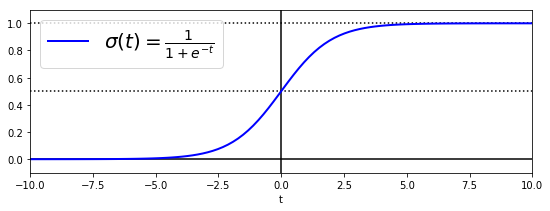

In [48]:
t = np.linspace(-10, 10, 100)
sig = 1/(1 + np.exp(-t))
plt.figure(figsize = (9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

In [49]:
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names']

In [50]:
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

使用一个特征

In [54]:
X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(np.int)

In [55]:
log_reg = LogisticRegression(solver = "liblinear", random_state = 42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

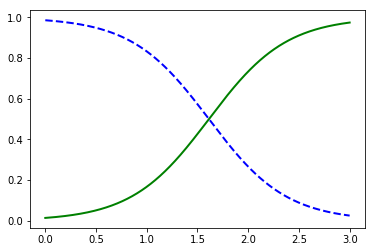

In [56]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")

In [57]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

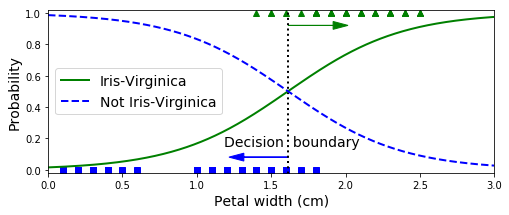

In [58]:
plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [59]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

使用两个特征

In [60]:
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

In [62]:
log_reg = LogisticRegression(solver = "liblinear", C= 10**10, random_state = 42)
log_reg.fit(X, y)



LogisticRegression(C=10000000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [66]:
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )

X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

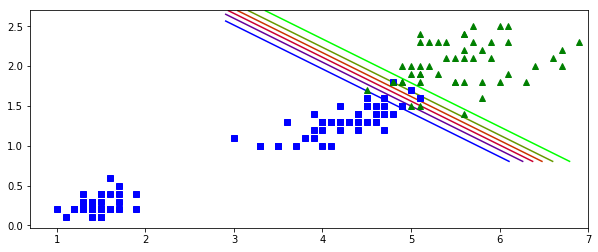

In [67]:
plt.figure(figsize = (10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs")
plt.plot(X[y == 1, 0], X[y == 1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

In [68]:
left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]


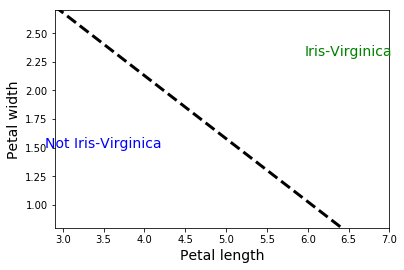

In [69]:
plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

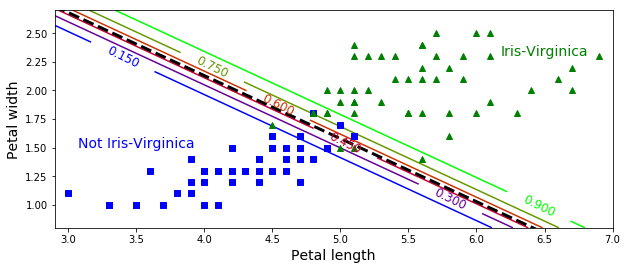

In [70]:
plt.figure(figsize = (10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs")
plt.plot(X[y == 1, 0], X[y == 1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

**多标签分类**

In [71]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

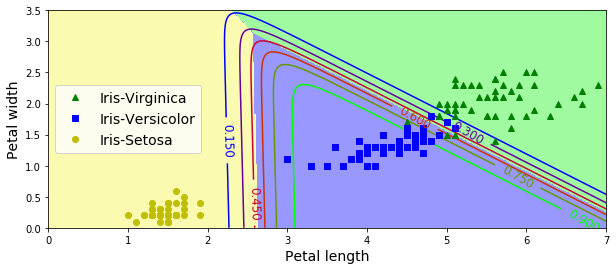

In [73]:
plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [74]:
softmax_reg.predict([[5, 2]])

array([2])

In [75]:
softmax_reg.predict_proba([[5, 2]])

array([[6.33134077e-07, 5.75276067e-02, 9.42471760e-01]])